In [1]:
from sklearn.datasets import load_files
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import numpy as np
from glob import glob
import random
import cv2
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD,Adagrad,Adam, Nadam
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
import matplotlib.pyplot as plt     
from keras.preprocessing import image                  
from tqdm import tqdm
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D,GlobalMaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import log_loss
from keras import optimizers
import math
import pickle
import os
import pandas as pd
import datetime
from keras.models import Model
from keras.layers import Input
from IPython.display import clear_output
from keras.callbacks import EarlyStopping, Callback

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure(figsize=(3,2))
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        #clear_output(wait=False)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend(['train', 'test'], loc='upper left')
        plt.show();
        


def model_history(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def save_model(model):
    json_string = model.to_json()
    if not os.path.isdir('cache'):
        os.mkdir('cache')
    open(os.path.join('cache', 'model_vgg16.json'), 'w').write(json_string)


def read_model():
    model = model_from_json(open(os.path.join('cache', 'model_vgg16.json')).read())
    return model

def create_submission(predictions, test_id, loss):
    print('Started building csv file')
    result1 = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result1.insert(loc=0, column='img', value=test_id)
    now = datetime.datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    suffix = str(round(loss, 6)) + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('subm', 'submission_' + suffix + '.csv')
    result1.to_csv(sub_file, index=False)
    print("successfully created submission")   
    
def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()

def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data

def read_imc(path):
    # Load as grayscale
    #img = cv2.imread(path, 0)
    # Reduce size
    #resized = cv2.resize(img, (224, 224))
    #x = image.img_to_array(path)
    #resized=np.expand_dims(x, axis=0)
    img = cv2.imread(path)
    img_rows, img_cols=224,224
   # resized = cv2.resize(img, (96, 128), cv2.INTER_LINEAR)
    resized = cv2.resize(img, (img_rows, img_cols))
    return resized

def get_driver_data():
    dr = dict()
    clss = dict()
    path ='Data/driver_imgs_list.csv'
    print('Read drivers data')
    f = open(path, 'r')
    line = f.readline()
    while (1):
        line = f.readline()
        if line == '':
            break
        arr = line.strip().split(',')
        dr[arr[2]] = arr[0]
        if arr[0] not in clss.keys():
            clss[arr[0]] = [(arr[1], arr[2])]
        else:
            clss[arr[0]].append((arr[1], arr[2]))
    f.close()
    return dr, clss

def load_train():
    #path='Data/imgs/train'
    #data=load_files(path)
    #driver_file=np.array(data['filenames'])
    #driver_target=np_utils.to_categorical(np.array(data['target']),10)
    #data=glob(path)
    driver_file=[]
    driver_target=[]
    driver_id=[]
    driver_file_id=[]
    driver_data, dr_class = get_driver_data()
    print('driver data and class sample',len(driver_data),len(dr_class))
    for j in range(10):
        print('Load folder c{}'.format(j))
        path = os.path.join( 'Data', 'imgs', 'train', 'c' + str(j), '*.jpg')
        data = glob(path)
        for p in data:
            
            driver_file.append(read_imc(p))
            driver_target.append(j)
            base = os.path.basename(p)
            driver_file_id.append(base)
            driver_id.append(driver_data[base])
            #print(driver_data[base])
    unique_drivers = sorted(list(set(driver_id)))
    print('Unique drivers: {}'.format(len(unique_drivers)))
    print(unique_drivers)
    return driver_file,driver_target,driver_file_id,driver_id,unique_drivers

def load_test():
    path='Data/imgs/test/*'
    data=glob(path)
    driver_file=[]
    driver_id=[]  
    for p in data:
        driver_file.append(read_imc(p))
        driver_id.append(os.path.basename(p))
        
   # driver_id=os.path.basename(p)
    #test_id=np.array(driver_file['target'])
    return driver_file,driver_id

def split_list_trial(l,size):
    return [l[i:i + size] for i in range(0, len(l), size)]

def split_list(l,size):
    return [l[i*len(l) // size: (i+1)*len(l) // size] for i in range(size)]

def load_test_parts(part,splits):
    path='Data/imgs/test/*'
    data=glob(path)
    driver_file=[]
    driver_id=[]  
    test_chunks=split_list(data,splits)
    
    for p in test_chunks[part]:
        driver_file.append(read_imc(p))
        driver_id.append(os.path.basename(p))
        
    #del data
    #del test_chunks
   # driver_id=os.path.basename(p)
    #test_id=np.array(driver_file['target'])
    return driver_file,driver_id

def append_chunk(main, part):
    for p in part:
        main.append(p)
        
    return main

def print_sample(data,target):
    print ("X shape",data.shape) 
    print ("Y shape",target.shape)
    
   # for p in data[:2]: print (p)
  #  for p in target[:2]: print (p)
    #im = cv2.imread(data[1])
    # show sample image   
    #plt.imshow(im)
    #plt.show()
    return None

def get_selected_drivers(train_data, train_target, driver_id, driver_list):
    data = []
    target = []
    index = []
   
    for i in range(len(train_data)):
        if driver_id[i] in driver_list:
            data.append(train_data[i])
            target.append(train_target[i])
          #  index.append(i)
    del train_data
    del train_target
    del driver_id
    del driver_list
    data = np.array(data,dtype=np.uint8)
    target = np.array(target,dtype=np.uint8)
    #index = np.array(index,dtype=np.uint8)
    #print('driver list length',len(driver_list))
    return data, target #, index

def get_val_selected_drivers(train_data, train_target, driver_id, driver_list):
    data = []
    target = []
    index = []
   
    for i in range(len(train_data)):
        if driver_id[i] in driver_list:
            data.append(train_data[i])
            target.append(train_target[i])
            index.append(i)
    del train_data
    del train_target
    del driver_id
    del driver_list
    data = np.array(data,dtype=np.float32)
    target = np.array(target,dtype=np.uint8)
    index = np.array(index)
    #print('driver list length',len(driver_list))
    return data, target, index

def data_split(data,target,test_size,driver_id,driver_list):
 #   if unique==True:
        
       # perm = np.random.permutation(len(target))
        #x,y = data[perm], target[perm]
        #unique_list_train = [unique_drivers[i] for i in train_drivers]
        
        #drivers_list=drivers_list[perm]
        random.shuffle(driver_list)
        #test_size=0.2
        test_split=test_size*len(driver_list)
        test_split=int(round(test_split))
       
        train_list=driver_list[test_split:]
        test_list=driver_list[:test_split]
        
        X_train,y_train = get_selected_drivers(data,target,driver_id,train_list)
        X_test,y_test = get_selected_drivers(data,target,driver_id,test_list)
        
       # perm = np.random.permutation(len(y_train))
       # X_train,y_train = X_train[perm], y_train[perm]
        
       # perm = np.random.permutation(len(y_test))
       # X_test,y_test = X_test[perm], y_test[perm]
        
       # print('Train shape',train_list )
       # print('Test shape',test_list)

  #  else:    
   #     X_train, X_split, y_train, y_split = train_test_split(data,target,test_size=test_size,random_state=42)
    
        return X_train, X_test, y_train, y_test, test_list
    




img_rows=224
img_cols=224
img_channel=3  

batch_size=32
nfolds=3

Using TensorFlow backend.


Restore train from cache
Start KFold number 1 from 3
Split train:  15098 15098
Split valid:  7326 7326
Train drivers:  ['p002', 'p015', 'p016', 'p021', 'p022', 'p035', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p064', 'p066', 'p075', 'p081']
Test drivers:  ['p012', 'p014', 'p024', 'p026', 'p039', 'p041', 'p056', 'p061', 'p072']
Score log_loss:  0.501474459287
Start KFold number 2 from 3
Split train:  14417 14417
Split valid:  8007 8007
Train drivers:  ['p002', 'p012', 'p014', 'p021', 'p024', 'p026', 'p035', 'p039', 'p041', 'p050', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Test drivers:  ['p015', 'p016', 'p022', 'p042', 'p045', 'p047', 'p049', 'p051', 'p052']
Score log_loss:  0.348811449505
Start KFold number 3 from 3
Split train:  15333 15333
Split valid:  7091 7091
Train drivers:  ['p012', 'p014', 'p015', 'p016', 'p022', 'p024', 'p026', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p051', 'p052', 'p056', 'p061', 'p072']
Test drivers:  ['p002', 'p021', 'p

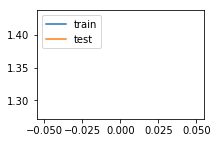

Epoch 00001: val_loss improved from inf to 1.27944, saving model to cache\weights_kfold_augmented_vgg19_3.h5


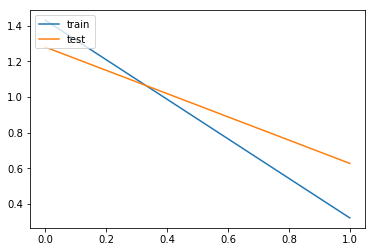

Epoch 00002: val_loss improved from 1.27944 to 0.62712, saving model to cache\weights_kfold_augmented_vgg19_3.h5


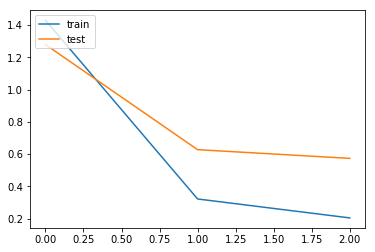

Epoch 00003: val_loss improved from 0.62712 to 0.57313, saving model to cache\weights_kfold_augmented_vgg19_3.h5


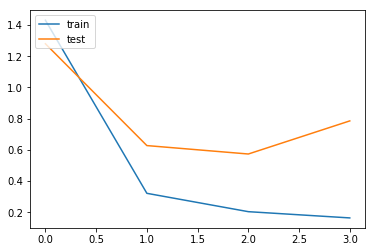

Epoch 00004: val_loss did not improve


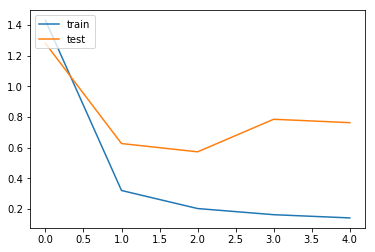

Epoch 00005: val_loss did not improve


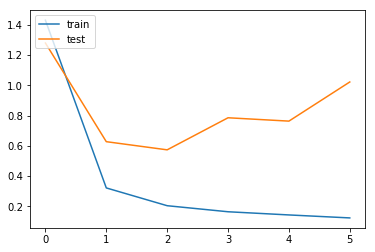

Epoch 00006: val_loss did not improve


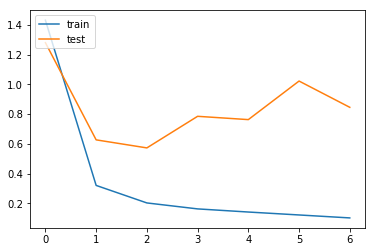

Epoch 00007: val_loss did not improve


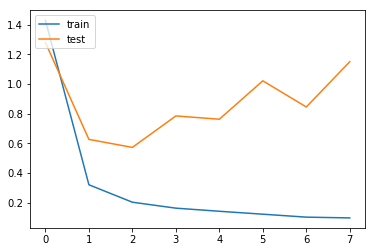

Epoch 00008: val_loss did not improve


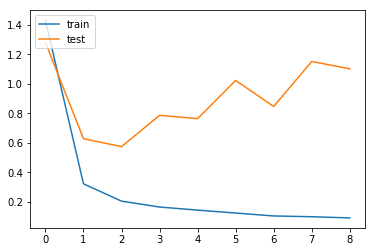

Epoch 00009: val_loss did not improve


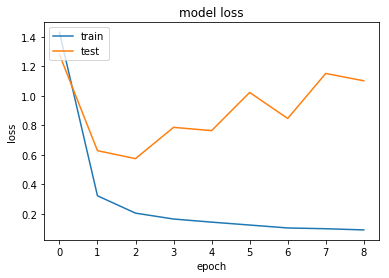

Score log_loss:  0.573127434894
Log_loss train independent avg:  0.469621022376
Train files:  22424
yFullTrain:  22424
Final log_loss: 0.4696210223757866, nfolds: 3 epoch: 20


In [2]:
 
#from sklearn.cross_validation import KFold 
from sklearn.model_selection import KFold 
from keras.regularizers import l1,l2,l1_l2
from keras.layers.noise import AlphaDropout

def model_arch():
    base_model = VGG19(input_shape=(224,224,3),weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    #x = MaxPooling2D(pool_size=2)(x)v
    #x = GlobalAveragePooling2D()(x)
    
    x = GlobalMaxPooling2D()(x)
   # x=Flatten()(x)
    # let's add a fully-connected layer
  
    #x = Dropout(0.1)(x)
    #x = Dense(1024, kernel_initializer='lecun_normal',activation='selu')(x)
    #x = AlphaDropout(0.2, seed=51)(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(10, activation='softmax')(x)  
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    #model.compile(optimizer=SGD(lr=0.0009, momentum=0.9), loss='categorical_crossentropy')
   # model.compile(optimizer=SGD(lr=0.0009, momentum=0.9,nesterov=True), loss='categorical_crossentropy')
    model.compile(optimizer=SGD(lr=0.0009,momentum=0.9,nesterov=True),loss='categorical_crossentropy')
    #model.compile(optimizer=Nadam(lr=0.0007),loss='categorical_crossentropy')
  #  model.compile(optimizer='nadam',loss='categorical_crossentropy')
    return model

def model_arch2():
    base_model = ResNet50(input_shape=(224,224,3),weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    #x = MaxPooling2D(pool_size=2)(x)v
    x = GlobalAveragePooling2D()(x)
    
  #  x = GlobalMaxPooling2D()(x)
   # x=Flatten()(x)
    # let's add a fully-connected layer
  
    #x = Dropout(0.1)(x)
    #x = Dense(1024, kernel_initializer='lecun_normal',activation='selu')(x)
    #x = AlphaDropout(0.2, seed=51)(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(10, activation='softmax')(x)  
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    #model.compile(optimizer=SGD(lr=0.0009, momentum=0.9), loss='categorical_crossentropy')
    model.compile(optimizer=SGD(lr=0.0009, momentum=0.9,nesterov=True), loss='categorical_crossentropy')
    #model.compile(optimizer=SGD(lr=0.0005,momentum=0.9),loss='categorical_crossentropy')
    #model.compile(optimizer=Nadam(lr=0.0007),loss='categorical_crossentropy')
  #  model.compile(optimizer='nadam',loss='categorical_crossentropy')
    return model
 
def get_validation_predictions(train_data, predictions_valid):
    pv = []
    for i in range(len(train_data)):
        pv.append(predictions_valid[i])
    
    del train_data
    del predictions_valid
    return pv


class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
        
def run_cross_validation_create_models(nfolds):
    # input image dimensions
    #batch_size = 16
    #nfolds=2
    #epochs = 25
    epochs = 20
    random_state = 51
   
    cache_path= os.path.join('cache','train_224.dat')
    if not os.path.isfile(cache_path):
        print('building train cache')
        train_files,train_targets,train_id, driver_id, unique_drivers = load_train()
        cache_data((train_files,train_targets,train_id, driver_id, unique_drivers),cache_path)
        print('train cache built')           
    else:
        print('Restore train from cache')
        (train_files,train_targets,train_id, driver_id, unique_drivers)=restore_data(cache_path)
    
 
    #train_files =np.array(train_files,dtype=np.uint8)
   # train_files=train_files.astype('float32')
  #  train_files= train_files/255
  #  train_files=train_files.astype('uint8')
    #train_files = train_files.reshape(train_files.shape[0], img_rows, img_cols,img_channel)
    #train_targets=np.array(train_targets,dtype=np.uint8)
    
    yfull_train = dict()
    #kf = KFold( n_splits=nfolds, shuffle=True, random_state=random_state)
    kf = KFold(n_splits=nfolds, shuffle=True, random_state=random_state)
    num_fold = 0
    sum_score = 0
    for train_drivers, test_drivers in kf.split(unique_drivers):
        model = model_arch()
        unique_list_train = [unique_drivers[i] for i in train_drivers]
        X_train, Y_train  = get_selected_drivers(train_files, train_targets, driver_id, unique_list_train)
        unique_list_valid = [unique_drivers[i] for i in test_drivers]
        X_valid, Y_valid, test_index = get_val_selected_drivers(train_files, train_targets, driver_id, unique_list_valid)

        num_fold += 1
        print('Start KFold number {} from {}'.format(num_fold, nfolds))
        print('Split train: ', len(X_train), len(Y_train))
        print('Split valid: ', len(X_valid), len(Y_valid))
        print('Train drivers: ', unique_list_train)
        print('Test drivers: ', unique_list_valid)
        
       # X_train = X_train.astype('float32')
       # X_train/=255
        
       # X_valid = X_valid.astype('float32')
        #X_train=np.array(X_train,dtype=np.uint8)
        X_valid/=255
        
        
        train_datagen=ImageDataGenerator(
          rescale=1./255,
           #shear_range=0.2, 
           zoom_range=0.4,
           width_shift_range=0.4,
           height_shift_range=0.4, 
           rotation_range=0.2
           #horizontal_flip=True

            )

        val_datagen=ImageDataGenerator(
           #rescale=1./255, 
        #   zoom_range=0.1,
          # width_shift_range=0.1,
         #  height_shift_range=0.1, 
         #  horizontal_flip=False
            )
        
        Y_train=np_utils.to_categorical(Y_train,10)
        Y_valid=np_utils.to_categorical(Y_valid,10)
            
        kfold_weights_path = os.path.join('cache', 'weights_kfold_augmented_vgg19_' + str(num_fold) + '.h5')
        if not os.path.isfile(kfold_weights_path) :
            plot_losses = PlotLosses()
            callbacks = [
                
                EarlyStoppingByLossVal(monitor='val_loss', value=0.00001, verbose=1),
                EarlyStopping(monitor='val_loss', patience=6, verbose=0),
                plot_losses,
                ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=2),
                
            ]
            
          #  model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,
                #  shuffle=True, verbose=1, validation_data=(X_valid, Y_valid),
               #   callbacks=callbacks)
                
            X_train=X_train.astype('float32')
           
            print('X train shape',X_train.shape)
            
         #   X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols,img_channel)
            
         #   X_train = X_train.astype('float32')   
        #    X_valid = X_valid.astype('float32')
            
            
          #  X_train/=255
           # X_valid/=255
            
            #train_datagen.fit(X_train)
            #val_datagen.fit(X_valid)
            
            print('--finished pre processing--')
            
        
            history=model.fit_generator(train_datagen.flow(X_train,Y_train,batch_size=batch_size),
                            validation_data=(X_valid,Y_valid),
                    epochs=epochs ,use_multiprocessing=False,steps_per_epoch=len(X_train)/batch_size,
                            callbacks=callbacks,verbose=0) 
            model_history(history)
        if os.path.isfile(kfold_weights_path):
            model.load_weights(kfold_weights_path)

        # score = model.evaluate(X_valid, Y_valid, show_accuracy=True, verbose=0)
        # print('Score log_loss: ', score[0])
        del X_train
        
        predictions_valid = model.predict(X_valid, batch_size=batch_size, verbose=0)
        score = log_loss(Y_valid, predictions_valid)
        print('Score log_loss: ', score)
        sum_score += score*len(test_index)
        
        # Store valid predictions
       # print('predictions valid ',predictions_valid[0])
        for i in range(len(test_index)):
            yfull_train[test_index[i]] = predictions_valid[i]
        del test_index
        del train_datagen
        del model
        del predictions_valid
        del X_valid
        
    score = sum_score/len(train_files)
    print("Log_loss train independent avg: ", score)
    
    #train_files=np.array(train_files,dtype=np.float32)
    print('Train files: ', len(train_files))
    print('yFullTrain: ', len(yfull_train))
 #   yfull_train=yfull_train.astype('float32')

    print('Final log_loss: {}, nfolds: {} epoch: {}'.format(score, nfolds, epochs))
    info_string = 'loss_' + str(score) \
                    + '_folds_' + str(nfolds) \
                    + '_ep_' + str(epochs)

    predictions_valid = get_validation_predictions(train_files, yfull_train)
    

    score1 = log_loss(train_targets, predictions_valid)
    if abs(score1 - score) > 0.0001:
        print('Check error: {} != {}'.format(score, score1))
   
    

    
    
run_cross_validation_create_models(nfolds)

In [3]:
def merge_several_folds_mean(data, nfolds):
    a = np.array(data[0])
    for i in range(1, nfolds):
        a += np.array(data[i])
    a /= nfolds
    
    return a.tolist()

def run_model_test(nfolds):
    
    num_fold=0
    final_pred=[]
    cache_path= os.path.join('cache','test_split_224.dat')    
    if os.path.isfile(cache_path):
        print('Restore test split from cache')
        (X_test,y_test)=restore_data(cache_path)
    else:
        print('Test split data cache is empty')
    X_test=np.array(X_test,dtype=np.uint8)
     
    y_test=np.array(y_test,dtype=np.uint8)
  
    y_test=np_utils.to_categorical(y_test,10)   
        
    X_test = X_test.astype('float32')
        
    for i in range(nfolds):

        model= model_arch()
        num_fold+=1
        
        kfold_weights_path = os.path.join('cache', 'weights_kfold_augmented_vgg19_' + str(num_fold) + '.h5')
        model.load_weights(kfold_weights_path)
        
        predictions=model.predict(X_test, verbose=0)
        score=log_loss(y_test,predictions)
        
        final_pred.append(predictions)
        #print('fold # ', num_fold)
        print('pre pixel division check log_loss: ', score)
    
    result=merge_several_folds_mean(final_pred, nfolds)
    score=log_loss(y_test,result)
    print('pre pixel mean log_loss: ', score)
    
    X_test=X_test/255
    
    final_pred=[]
    num_fold=0
    
    for i in range(nfolds):
        model= model_arch()
        num_fold+=1
        kfold_weights_path = os.path.join('cache', 'weights_kfold_augmented_vgg19_' + str(num_fold) + '.h5')
        model.load_weights(kfold_weights_path)
        
        predictions=model.predict(X_test, verbose=0)
        score=log_loss(y_test,predictions)
        
        final_pred.append(predictions)
        print('post pixel check log_loss: ', score)
        
    result=merge_several_folds_mean(final_pred, nfolds)
    score=log_loss(y_test,result)
    print('post pixel mean log_loss: ', score)
    
    return score

def run_multi_model_test(nfolds):
    
    num_fold=0
    final_pred=[]
    cache_path= os.path.join('cache','test_split_224.dat')    
    if os.path.isfile(cache_path):
        print('Restore test split from cache')
        (X_test,y_test)=restore_data(cache_path)
    else:
        print('Test split data cache is empty')
    X_test=np.array(X_test,dtype=np.uint8)
     
    y_test=np.array(y_test,dtype=np.uint8)
  
    y_test=np_utils.to_categorical(y_test,10)   
        
    X_test = X_test.astype('float32')
        
    for i in range(nfolds):

        model= model_arch()
        num_fold+=1
        
        kfold_weights_path = os.path.join('cache', 'weights_kfold_augmented_vgg19_' + str(num_fold) + '.h5')
        model.load_weights(kfold_weights_path)
        
        predictions=model.predict(X_test, verbose=0)
        score=log_loss(y_test,predictions)
        
        final_pred.append(predictions)
        #print('fold # ', num_fold)
        print('pre pixel division check log_loss: ', score)
    
    result=merge_several_folds_mean(final_pred, nfolds)
    score=log_loss(y_test,result)
    print('pre pixel mean log_loss: ', score)
    
    X_test=X_test/255
    
    final_pred=[]
    num_fold=0
    dual_model=[]
    for i in range(nfolds):
        model= model_arch()
        num_fold+=1
        kfold_weights_path = os.path.join('cache', 'weights_kfold_augmented_vgg19_' + str(num_fold) + '.h5')
        model.load_weights(kfold_weights_path)
        
        predictions=model.predict(X_test, verbose=0)
        score=log_loss(y_test,predictions)
        
        final_pred.append(predictions)
        print('post pixel check log_loss: ', score)
        
    result=merge_several_folds_mean(final_pred, nfolds)
    score=log_loss(y_test,result)
    print('post pixel mean log_loss: ', score)
    
    dual_model.append(result)
    
    final_pred=[]
    num_fold=0
    
    for i in range(nfolds):
        model= model_arch2()
        num_fold+=1
        kfold_weights_path = os.path.join('cache', 'weights_kfold_augmented_resnet50_' + str(num_fold) + '.h5')
        model.load_weights(kfold_weights_path)
        
        predictions=model.predict(X_test, verbose=0)
        score=log_loss(y_test,predictions)
        
        final_pred.append(predictions)
        print('post pixel check log_loss: ', score)
        
    result=merge_several_folds_mean(final_pred, nfolds)
    
    score=log_loss(y_test,result)
    print('post pixel mean log_loss: ', score)
    
    dual_model.append(result)
    
    result=merge_several_folds_mean(dual_model,2)
    score=log_loss(y_test,result)
    print('dual model mean log_loss: ', score)
    
    return score


def run_cross_validation_submission(nfolds):    
    score=run_model_test(nfolds)
    #nfolds=5
    num_fold=0
    test_splits=5
    full_pred=[]
    full_test_id=[]
    for i in range(nfolds):

        model= model_arch()
        num_fold+=1
        print('Fold No. ',num_fold)
        kfold_weights_path = os.path.join('cache', 'weights_kfold_augmented_vgg19_' + str(num_fold) + '.h5')
        model.load_weights(kfold_weights_path)
        
        predictions=[]
        
        for x in range(test_splits):
            print('iteration: ',x)
           # cache_path=None
            part=x+1
            cache_path= os.path.join('cache','test_224_part'+str(part)+'.dat')

            if not os.path.isfile(cache_path):
                print('building test cache')
                test_files,test_id = load_test_parts(x,test_splits)
                cache_data((test_files,test_id),cache_path)
                print('test cache built')
            else:
                print('Restore test from cache')
                (test_files,test_id)=restore_data(cache_path)

            test_files=np.array(test_files,dtype=np.uint8)    
            test_files = test_files.reshape(test_files.shape[0], img_rows, img_cols,img_channel)
            test_files = test_files.astype('float32')

            print('test length',test_files.shape)
            test_files/=255

            prediction=model.predict(test_files,  batch_size=batch_size)
            predictions=append_chunk(predictions,prediction)
            if num_fold==1:
                full_test_id=append_chunk(full_test_id,test_id)
            
            del test_files
        
        print('prediction length ',len(predictions))
        print('test id length ',len(full_test_id))
        full_pred.append(predictions)
        
        
        
    result=merge_several_folds_mean(full_pred, nfolds)   
   # score=0.05
    print('prediction length ',len(result))    
    create_submission(result,full_test_id,score) 

def run_multi_model_cross_validation_submission(nfolds):    
    score=run_multi_model_test(nfolds)
    
    dual_model=[]
    #nfolds=5
    num_fold=0
    test_splits=5
    full_pred=[]
    full_test_id=[]
    
    
    
    for i in range(nfolds):

        model= model_arch()
        num_fold+=1
        print('Fold No. ',num_fold)
        kfold_weights_path = os.path.join('cache', 'weights_kfold_augmented_vgg19_' + str(num_fold) + '.h5')
        model.load_weights(kfold_weights_path)
        
        predictions=[]
        
        for x in range(test_splits):
            print('iteration: ',x)
           # cache_path=None
            part=x+1
            cache_path= os.path.join('cache','test_224_part'+str(part)+'.dat')

            if not os.path.isfile(cache_path):
                print('building test cache')
                test_files,test_id = load_test_parts(x,test_splits)
                cache_data((test_files,test_id),cache_path)
                print('test cache built')
            else:
                print('Restore test from cache')
                (test_files,test_id)=restore_data(cache_path)

            test_files=np.array(test_files,dtype=np.uint8)    
            test_files = test_files.reshape(test_files.shape[0], img_rows, img_cols,img_channel)
            test_files = test_files.astype('float32')

            print('test length',test_files.shape)
            test_files/=255

            prediction=model.predict(test_files,  batch_size=batch_size)
            predictions=append_chunk(predictions,prediction)
            if num_fold==1:
                full_test_id=append_chunk(full_test_id,test_id)
            
            del test_files
        
        print('prediction length ',len(predictions))
        print('test id length ',len(full_test_id))
        full_pred.append(predictions)
        
        
        
    result=merge_several_folds_mean(full_pred, nfolds)
    dual_model.append(result)
    
    
  
    num_fold=0
    test_splits=5
    full_pred=[]
    
    
    
    for i in range(nfolds):

        model= model_arch2()
        num_fold+=1
        print('Fold No. ',num_fold)
        kfold_weights_path = os.path.join('cache', 'weights_kfold_augmented_resnet50_' + str(num_fold) + '.h5')
        model.load_weights(kfold_weights_path)
        
        predictions=[]
        
        for x in range(test_splits):
            print('iteration: ',x)
           # cache_path=None
            part=x+1
            cache_path= os.path.join('cache','test_224_part'+str(part)+'.dat')

            if not os.path.isfile(cache_path):
                print('building test cache')
                test_files,test_id = load_test_parts(x,test_splits)
                cache_data((test_files,test_id),cache_path)
                print('test cache built')
            else:
                print('Restore test from cache')
                (test_files,test_id)=restore_data(cache_path)

            test_files=np.array(test_files,dtype=np.uint8)    
            test_files = test_files.reshape(test_files.shape[0], img_rows, img_cols,img_channel)
            test_files = test_files.astype('float32')

            print('test length',test_files.shape)
            test_files/=255

            prediction=model.predict(test_files,  batch_size=batch_size)
            predictions=append_chunk(predictions,prediction)
           
            
            del test_files
        
        print('prediction length ',len(predictions))
        print('test id length ',len(full_test_id))
        full_pred.append(predictions)
        
        
        
    result=merge_several_folds_mean(full_pred, nfolds)  
    dual_model.append(result)
    result=merge_several_folds_mean(dual_model, 2) 
    

   # score=0.05
    print('prediction length ',len(result))    
    create_submission(result,full_test_id,score)     
    
#run_model_test(5)
#run_cross_validation_submission(5)
run_model_test(nfolds)
#run_multi_model_test(nfolds)
#run_multi_model_cross_validation_submission(nfolds)
#run_cross_validation_submission(nfolds)

Restore test split from cache
pre pixel division check log_loss:  2.98876422916
pre pixel division check log_loss:  1.51716677477
pre pixel division check log_loss:  3.81282038056
pre pixel mean log_loss:  0.14553693389
post pixel check log_loss:  0.212205261865
post pixel check log_loss:  0.178469887832
post pixel check log_loss:  0.200658004951
post pixel mean log_loss:  0.0754614347378


0.075461434737766384

# SECTION USED ONLY TO SPLIT DATA

cache_path= os.path.join('cache','train_224.dat')
if not os.path.isfile(cache_path):
    print('building train cache')
    train_files,train_targets,train_id, driver_id, unique_drivers = load_train()
    cache_data((train_files,train_targets,train_id, driver_id, unique_drivers),cache_path)
    print('train cache built')           
else:
    print('Restore train from cache')
    (train_files,train_targets,train_id, driver_id, unique_drivers)=restore_data(cache_path)

train_files=np.array(train_files,dtype=np.uint8)

train_files = train_files.reshape(train_files.shape[0], img_rows, img_cols,img_channel)


test_size=0.3
X_train, X_split, y_train, y_split,split_driver_list =data_split(train_files,train_targets,test_size,driver_id,unique_drivers)

del train_files
del train_targets

test_size=0.4
X_test, X_val, y_test, y_val,val_driver_list = data_split(X_split,y_split,test_size,driver_id,split_driver_list)

cache_path= os.path.join('cache','train_split_224.dat')
if not os.path.isfile(cache_path):
    print('building train cache')
    cache_data((X_train,y_train),cache_path)
    print('train cache built')           

    
cache_path= os.path.join('cache','val_split_224.dat')
if not os.path.isfile(cache_path):
    print('building val cache')
    cache_data((X_val,y_val),cache_path)
    print('val cache built')           

    
cache_path= os.path.join('cache','test_split_224.dat')
if not os.path.isfile(cache_path):
    print('building test cache')
    cache_data((X_test,y_test),cache_path)
    print('test cache built')           
    


Restore train split from cache
Restore val split from cache
Epoch 00001: val_loss improved from inf to 2.23107, saving model to saved_models/weightsfromscratch.hdf5
Epoch 00002: val_loss improved from 2.23107 to 2.13158, saving model to saved_models/weightsfromscratch.hdf5
Epoch 00003: val_loss improved from 2.13158 to 1.93225, saving model to saved_models/weightsfromscratch.hdf5
Epoch 00004: val_loss improved from 1.93225 to 1.59040, saving model to saved_models/weightsfromscratch.hdf5
Epoch 00005: val_loss improved from 1.59040 to 1.20057, saving model to saved_models/weightsfromscratch.hdf5
Epoch 00006: val_loss improved from 1.20057 to 0.91013, saving model to saved_models/weightsfromscratch.hdf5
Epoch 00007: val_loss improved from 0.91013 to 0.75790, saving model to saved_models/weightsfromscratch.hdf5
Epoch 00008: val_loss improved from 0.75790 to 0.68605, saving model to saved_models/weightsfromscratch.hdf5
Epoch 00009: val_loss improved from 0.68605 to 0.65009, saving model to 

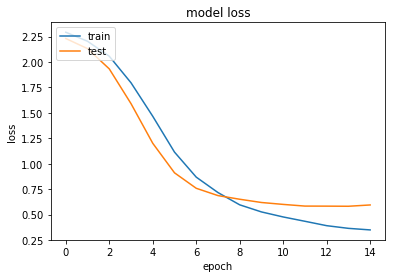

Restore test split from cache
Score log_loss:  0.619327433659


In [2]:
cache_path= os.path.join('cache','train_split_224.dat')   
if os.path.isfile(cache_path):
    print('Restore train split from cache')
    (X_train,y_train)=restore_data(cache_path)
else:
    print('train split data cache is empty')
    
X_train=np.array(X_train,dtype=np.uint8)
y_train=np.array(y_train,dtype=np.uint8)
y_train=np_utils.to_categorical(y_train,10)

#train_files = train_files.reshape(train_files.shape[0], img_rows, img_cols,img_channel)
    
    
cache_path= os.path.join('cache','val_split_224.dat')   
if os.path.isfile(cache_path):
    print('Restore val split from cache')
    (X_val,y_val)=restore_data(cache_path)
else:
    print('val split data cache is empty')
    
X_val=np.array(X_val,dtype=np.uint8)
y_val=np.array(y_val,dtype=np.uint8)
y_val=np_utils.to_categorical(y_val,10)   


train_datagen=ImageDataGenerator(
   rescale=1./255,
   #shear_range=0.1,
   zoom_range=0.4,
   width_shift_range=0.4,
   height_shift_range=0.4, 
   horizontal_flip=False
    
    )

val_datagen=ImageDataGenerator(
   rescale=1./255, 
#   zoom_range=0.1,
  # width_shift_range=0.1,
 #  height_shift_range=0.1, 
 #  horizontal_flip=False
    )


### TODO: Define your architecture.



#input_tensor = Input(shape=(224, 224, 3))
base_model = InceptionResNetV2(input_shape=(224,224,3),weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
#x=Flatten()(x)
x = GlobalAveragePooling2D()(x)
#x = GlobalMaxPooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
#x = Dense(512, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

#model.compile(optimizer=SGD(lr=0.0009, momentum=0.9), loss='categorical_crossentropy')
#model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

train_datagen.fit(X_train)
val_datagen.fit(X_val)

model.compile(optimizer=SGD(lr=0.0009, momentum=0.7), loss='categorical_crossentropy')
#model.compile(optimizer=SGD(lr=1e-3), loss='categorical_crossentropy')

checkpointer = ModelCheckpoint(filepath='saved_models/weightsfromscratch.hdf5', 
                               verbose=1, save_best_only=True)
epochs=15

history=model.fit_generator(train_datagen.flow(X_train,y_train,batch_size=batch_size),
                            validation_data=val_datagen.flow(X_val,y_val),
                    steps_per_epoch=len(X_train)//batch_size,validation_steps=len(X_val)//batch_size,epochs=epochs,
                            callbacks=[checkpointer],verbose=0)
save_model(model)
model_history(history)


#model.load_weights('saved_models/weightsfromscratch.hdf5')
#score = model.evaluate(X_test, y_test, verbose=1)
#print(score)

cache_path= os.path.join('cache','test_split_224.dat')    
if os.path.isfile(cache_path):
    print('Restore test split from cache')
    (X_test,y_test)=restore_data(cache_path)
else:
    print('Test split data cache is empty')
X_test=np.array(X_test,dtype=np.uint8)
y_test=np.array(y_test,dtype=np.uint8)
y_test=np_utils.to_categorical(y_test,10)   

X_test = X_test.astype('float32')
X_test/=255
predictions=model.predict(X_test, verbose=0)
score=log_loss(y_test,predictions)
print('Score log_loss: ', score)
   

global average pooling Xception Score log_loss:  2.2960430687
global max pooling Xception Score log_loss:  2.29670835679
global average pooling resnet Score log_loss:  5.34713518405
Global average pooling vgg19 Score log_loss:  31.0368328663
Global average pooling inceptionv3 Score log_loss:  1.95701219222
Global max pooling inceptionv3 Score log_loss:  30.0924949305
Global average pooling vgg16 Score log_loss:  30.9338345272
Global max pooling vgg16 Score log_loss:  30.6248395097
Global average pooling mobilenet Score log_loss:  2.47601450317
Dense 512 Inceptionv3 Score log_loss:  1.37379334373

In [2]:
model = read_model()
model.load_weights('saved_models/weightsfromscratch.hdf5')
    #model.compile(loss='categorical_crossentropy', optimizer='adadelta')
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
print('read and compiled model')
    

read and compiled model


In [3]:


predictions=[]
test_ids=[]
test_splits=5
for x in range(test_splits):
    print('iteration: ',x)
   # cache_path=None
    y=x+1
    cache_path= os.path.join('cache','test_224_part'+str(y)+'.dat')

    if not os.path.isfile(cache_path):
        print('building test cache')
        test_files,test_id = load_test_parts(x,test_splits)
        cache_data((test_files,test_id),cache_path)
        print('test cache built')
    else:
        print('Restore test from cache')
        (test_files,test_id)=restore_data(cache_path)
    
    test_files=np.array(test_files,dtype=np.uint8)    
    test_files = test_files.reshape(test_files.shape[0], img_rows, img_cols,img_channel)
    test_files = test_files.astype('float32')
  
    print('test length',test_files.shape)
    test_files/=255
    
    prediction=model.predict(test_files,  batch_size=batch_size)
    predictions=append_chunk(predictions,prediction)
    test_ids=append_chunk(test_ids,test_id)
    del test_files
    print('prediction length ',len(predictions))
   # np.stack(test_ids,test_id)
    print('test id length ',len(test_ids))
score=2.022
print('prediction length ',len(predictions))
create_submission(predictions,test_ids,score)    

iteration:  0
Restore test from cache
test length (15945, 224, 224, 3)
prediction length  15945
test id length  15945
iteration:  1
Restore test from cache
test length (15945, 224, 224, 3)
prediction length  31890
test id length  31890
iteration:  2
Restore test from cache
test length (15945, 224, 224, 3)
prediction length  47835
test id length  47835
iteration:  3
Restore test from cache
test length (15945, 224, 224, 3)
prediction length  63780
test id length  63780
iteration:  4
Restore test from cache
test length (15946, 224, 224, 3)
prediction length  79726
test id length  79726
prediction length  79726
Started building csv file
successfully created submission
